# Homework 7 Solution

**MECH.5130: Theory of Finite Element Analysis**

Michael N. Olaya

## Problem 1

![key_funcs](../figs/hw7_funcs.png)
![bubble_charts](../figs/hw7_bubblechart.png)

## Problem 2

### apply_disp_bcs

```Python
# Input: 
    # x_disp: dict[int, float]
    # y_disp: dict[int, float]
    # K: ndarray (ndof*num_nodes x ndof*num_nodes)
    # F: ndarray (ndof*num_nodes x 1)
    # (Optional) penalty_scale: float = 1e6
# Compute C = max(abs(K))*1e6
# For each global node number in x_disp dictionary...
    # Get index i linking local to global of stiffness/force for dof 1
    # Update K: K[i, i] = K[i, i] + C
    # Update F: F[i, 1] = F[i, 1] + disp
# For each global node number in y_disp dictionary...
    # Get index i linking local to global of stiffness/force for dof 2
    # Update K: K[i, i] = K[i, i] + C
    # Update F: F[i, 1] = F[i, 1] + disp
# Output: 
    # np.ndarray (ndof*num_nodes x ndof*num_nodes)
    # np.ndarray (ndof*num_nodes x 1)
```

### build_assembly_coord_grid

```Python
# Input: 
    # G: ndarray (num_elems x max(num_nodes))
    # elems: list[mfe.baseclasses.Element2D]
    # natural_grid: ndarray (n x m)
# For each elemental row of G...
    # Map natural grid to element using global element coordinates
    # Add to list of global element coordinates
# Stack list into single array and return
# Output: 
    # np.ndarray (n x m x ndof x 1)
```

### map_nodal_field_assembly

```Python
# Input: 
    # G: ndarray (num_elems x max(num_nodes))
    # elems: list[mfe.baseclasses.Element2D]
    # Q: ndarray (ndof*num_nodes x 1)
    # natural_grid: ndarray (n x m)
# For each elemental row of G...
    # Create list of field values for the element
    # For each node on the element
        # For each dof
            # Get global index corresponding to node, dof
            # Update list of field values for element
    # Assemble field values into array
    # Add to list of global field values
# Stack list into single array and return
# Output: 
    # np.ndarray (n x m x ndof x 1)
```

## Problem 3

In [32]:
import pathlib

import numpy as np
import matplotlib.pyplot as plt

import mfe.baseclasses
import mfe.solve
import mfe.utils
import mfe.load
import mfe.plot
import mfe.elem_lib

MESH_FILES = {
    'connectivity': pathlib.Path('../hw6/p6_connectivity.csv'),
    'node_coords': pathlib.Path('../hw6/p6_nodes.csv')
}

In [33]:
# Construct element and surface traction
elem = mfe.elem_lib.Linear2D.from_element_coords([np.array([0, 0]), np.array([12, 1]), np.array([15, 8]), np.array([-1, 10])])
surf_traction = mfe.load.SurfaceTraction.generate(elem, '+x', constants=[np.array([3, 3]), np.array([0, 5])], thickness=1.3)

# Update element material properties and thickness
elem.D = mfe.baseclasses.Material(E=70000, nu=0.33).D_isotropic_plane_stress()
elem.thickness = 1.3

# Compute the element stiffness matrix
k = elem.compute_k()
f = surf_traction.compute_force_vector(elem)
print(f)

[[  0.        ]
 [  0.        ]
 [207.91061271]
 [321.76642526]
 [222.76135642]
 [346.51766478]
 [  0.        ]
 [  0.        ]]


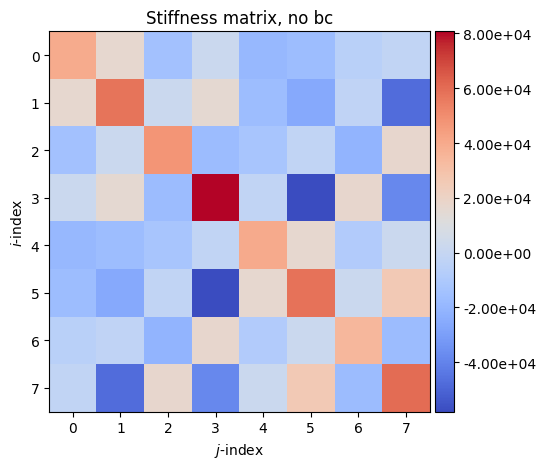

In [34]:
# Plot k heatmap
fig, ax = plt.subplots()
mfe.plot.plot_stiffness_heatmap(fig, ax, k)
ax.set_title(r'Stiffness matrix, no bc')
fig.tight_layout()

In [35]:
# Create bcs
disp = {
    'x_disp': {
        1: 0,
        4: 0,
    },
    'y_disp': {
        1: 0,
    }
}

# Apply bcs
k, f = mfe.solve.apply_disp_bcs(disp['x_disp'], disp['y_disp'], k, f)

### MFE solution

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'u$_{1}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
        <Axes: title={'center': 'u$_{2}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
       dtype=object))

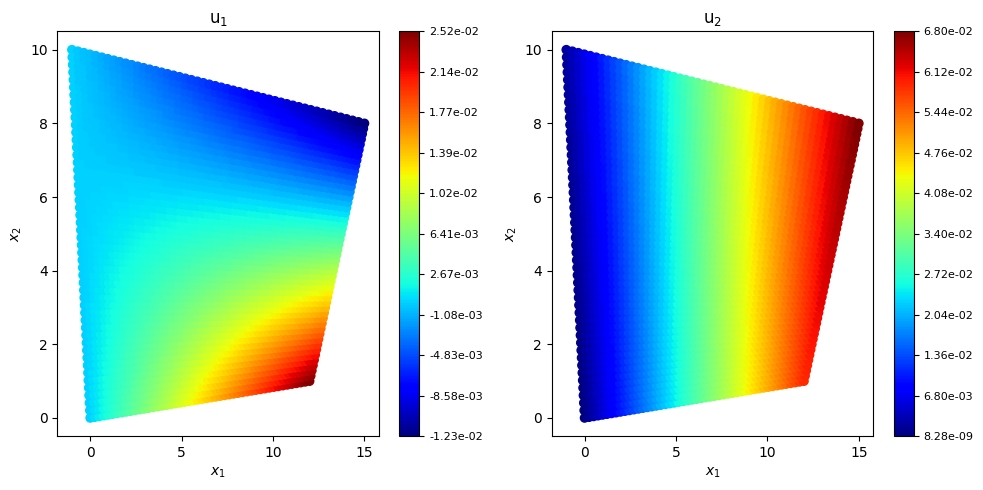

In [36]:
# Solve for nodal displacements
q = np.matmul(np.linalg.inv(k), f)

# Map to element
natural_grid = mfe.utils.make_natural_grid()
x_elem = elem.map_to_element(elem.x_element, natural_grid)
q_elem = elem.map_to_element(q, natural_grid)

# Plot
mfe.plot.plot_element_displacement(q_elem, x_elem, method='scatter')

### Verification with Abaqus (undeformed view)

![hw7_p3](../figs/hw7_p3.png)

## Problem 4

In [37]:
# Get connectivity matrix and nodal coordinates, then assemble the mesh
G, node_coords = mfe.utils.read_mesh_from_csv(**MESH_FILES)
elems = mfe.solve.assemble_mesh(G, node_coords)

In [38]:
# Set the element material property matrix and thickness
D = mfe.baseclasses.Material(E=70000, nu=0.33).D_isotropic_plane_strain()
thickness = 1.3
for e in elems:
    e.D = D.copy()
    e.thickness = thickness

# Create displacement bc dict
disp = {
    'x_disp': {
        26: 0,
        21: 0,
        13: 0,
        8: 0,
        5: 0,
    },
    'y_disp': {
        16: 0,
        17: 0,
        18: 0,
        19: 0,
        22: 0,
    }
}

# Set the traction boundary conditions corresponding to elements 1 and 2
constants = [
    np.array([0]), 
    [
        np.array([0, -50]), np.array([0, 100]),
    ]
]
loads = [[] for _ in elems]
loads[0] = mfe.load.SurfaceTraction.generate(elems[0], '+y', constants, thickness=elems[0].thickness)
loads[1] = mfe.load.SurfaceTraction.generate(elems[1], '+y', constants, thickness=elems[1].thickness)

# Assemble solution matrices
K, F = mfe.solve.assemble_global_solution(G, elems, loads, 2)

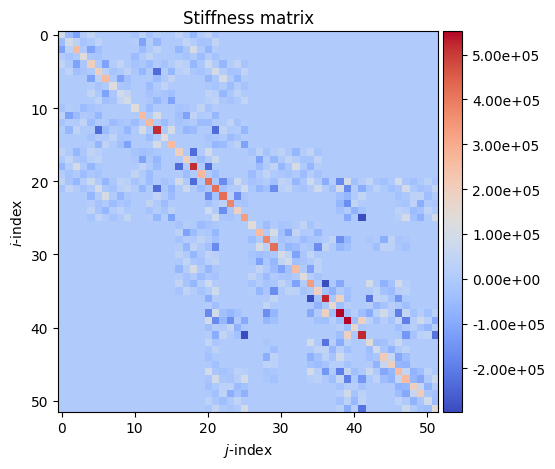

In [39]:
# Plot stiffness
fig, ax = plt.subplots()
mfe.plot.plot_stiffness_heatmap(fig, ax, K)
fig.tight_layout()

In [40]:
# Apply displacement boundary conditions and compute nodal displacements
K, F = mfe.solve.apply_disp_bcs(disp['x_disp'], disp['y_disp'], K, F)
Q = np.matmul(np.linalg.inv(K), F)

### MFE solution

(<Figure size 1000x500 with 4 Axes>,
 array([<Axes: title={'center': 'u$_{1}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>,
        <Axes: title={'center': 'u$_{2}$'}, xlabel='$x_{1}$', ylabel='$x_{2}$'>],
       dtype=object))

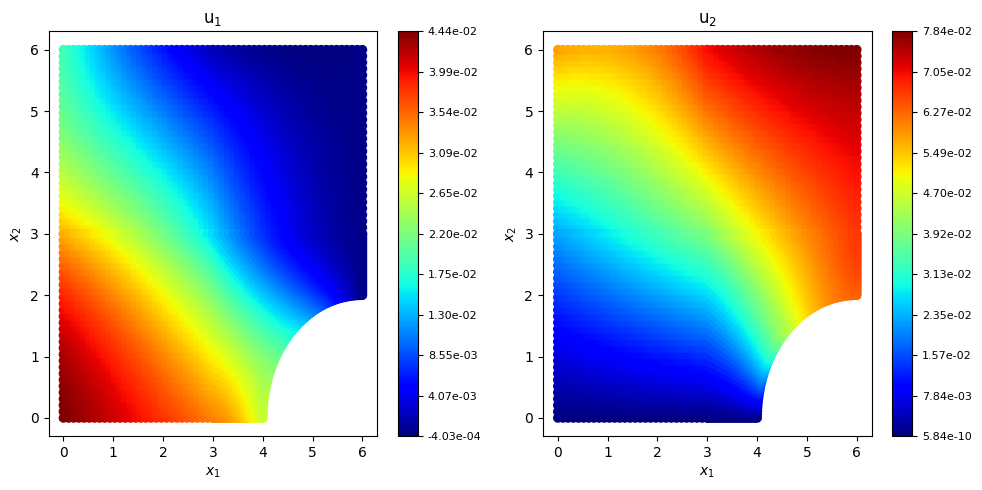

In [41]:
# Plot on assembly
natural_grid = mfe.utils.make_natural_grid(30)
x_assembly = mfe.solve.build_assembly_coord_grid(G, elems, natural_grid)
Q_assembly = mfe.solve.map_nodal_field_to_assembly(G, elems, Q, natural_grid)
mfe.plot.plot_element_displacement(Q_assembly, x_assembly, method='scatter')

### Verification with Abaqus (undeformed view)

![hw7_p3](../figs/hw7_p4.png)